<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/Ahn_gene_expression_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request

In [2]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

# control genes
genes_c = genes[(pd.isna(genes.sym)) & (pd.isna(genes.chrom))]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 363 kB 15.0 MB/s 


# Data Preparation

`michigan` dataset contains the measurements, done at University of Michigan lab, of anterior cortex and dorsolateral cortex for each patient. 

`michigan_diff` subtracts measurement of anterior cortex from the dorsolateral cortex for each patient.

In [3]:
# Michigan
michigan = expression[(expression.index.str[5] == 'M') & (expression.index.str[3] != 'c') ]
michigan_diff = michigan.diff().iloc[1::2,:]
michigan_diff.index = "patient" + michigan_diff.index.str[:2]
#michigan_diff

# Davis
davis = expression[(expression.index.str[5] == 'D') & (expression.index.str[3] != 'c') ]
davis = davis[~davis.index.str[1].isin(['1', '2', '5', '6', '7', '9'])]
#davis

# Irvine
irvine = expression[(expression.index.str[5] == 'I') & (expression.index.str[3] != 'c') ]
irvine_diff = irvine.diff().iloc[1::2,:]
irvine_diff.index = "patient" + irvine_diff.index.str[:2]
#irvine_diff

# Hypothesis testing 
Wilcoxon signed-rank test/paired t-test for each gene excluding controls
Tests whether the median of the difference is 0/mean of the difference is 0.  
Wilcoxon signed-rank test: A non-parametric alternative test to the paired t-test. 

## Multiple Hypotheses Testing on the actual data

Wilcoxon signed-rank test
Michigan
rejected H0(no correction):11181
rejected H0(bonferroni):0
rejected H0(BH):11122 

Irvine
rejected H0(no correction):10
rejected H0(bonferroni):0
rejected H0(BH):0 



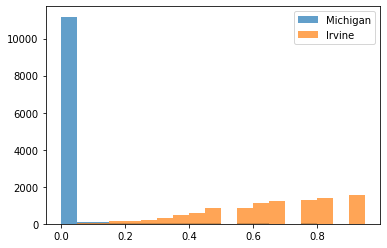

In [4]:
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

# `pvals` stores the pvalues, `rejected` stores the rejected H0 from the multiple hypothesis testing
pvals = {}
rejected = {}

# Remove controls
michigan_diff = michigan_diff[[c for c in michigan_diff.columns if c not in genes_c.index]]
irvine_diff = irvine_diff[[c for c in irvine_diff.columns if c not in genes_c.index]]

# Wilcoxon signed-rank test
p_val = michigan_diff.apply(wilcoxon).iloc[1,:]  ; pvals['michigan_w'] = p_val
bonferr = multipletests(p_val, method='bonferroni')[0]  ; rejected['michigan_w_b'] = bonferr
bh = multipletests(p_val, method='fdr_bh')[0]   ; rejected['michigan_w_bh'] = bh
print('Wilcoxon signed-rank test')
print('Michigan')
print('rejected H0(no correction):{}'.format(sum(p_val<0.05)))
print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
print('rejected H0(BH):{} \n'.format(sum(bh)))
plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.7, label='Michigan')

p_val = irvine_diff.apply(wilcoxon).iloc[1,:]   ; pvals['irvine_w'] = p_val
bonferr = multipletests(p_val, method='bonferroni')[0]  ; rejected['irvine_w_b'] = bonferr
bh = multipletests(p_val, method='fdr_bh')[0]  ; rejected['irvine_w_bh'] = bh
print('Irvine')
print('rejected H0(no correction):{}'.format(sum(p_val<0.05)))
print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
print('rejected H0(BH):{} \n'.format(sum(bh)))
plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.7, label='Irvine')
plt.legend()

Paired t-test
Michigan
rejected H0(no correction):11206
rejected H0(bonferroni):458
rejected H0(BH):11196 

Irvine
rejected H0(no correction):4
rejected H0(bonferroni):0
rejected H0(BH):0 



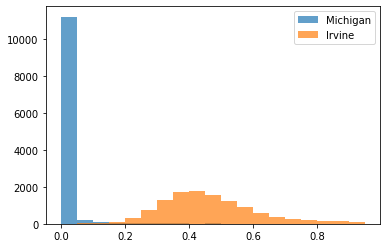

In [5]:
# Paired t-test

from scipy.stats import ttest_1samp
# Michigan
p_val = [ttest_1samp(michigan_diff.iloc[:,i], 0)[1] for i in np.arange(michigan_diff.shape[1])]
pvals['michigan_t'] = p_val

bonferr = multipletests(p_val, method='bonferroni')[0]  ; rejected['michigan_t_b'] = bonferr
bh = multipletests(p_val, method='fdr_bh')[0]   ; rejected['michigan_t_bh'] = bh
print('Paired t-test')
print('Michigan')
print('rejected H0(no correction):{}'.format(sum([i<0.05 for i in p_val])))
print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
print('rejected H0(BH):{} \n'.format(sum(bh)))
plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.7, label='Michigan')

# Irvine
p_val = [ttest_1samp(irvine_diff.iloc[:,i], 0)[1] for i in np.arange(irvine_diff.shape[1])]
pvals['irvine_t'] = p_val

bonferr = multipletests(p_val, method='bonferroni')[0]  ; rejected['irvine_t_b'] = bonferr
bh = multipletests(p_val, method='fdr_bh')[0]   ; rejected['irinve_t_bh'] = bh
print('Irvine')
print('rejected H0(no correction):{}'.format(sum([i<0.05 for i in p_val])))
print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
print('rejected H0(BH):{} \n'.format(sum(bh)))
plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.7, label='Irvine')
plt.legend()


## Multiple Hypothesis testing on the centered data
Lab-wise
1. Compute average measurements of the controls for each microarray. We assume the bacterial controls contain information about the microarray effect.
2. Centering: subtract the control average for each gene.
3. Do multiple hypothesis testing 


In [6]:
# Data Centering 

# Michigan
michigan = expression[(expression.index.str[5] == 'M') & (expression.index.str[3] != 'c') ]
control = michigan.filter(regex='AFFX').apply(np.mean, axis=1)

michigan_c = michigan.sub(control, axis='rows')
michigan_c_diff = michigan_c.diff().iloc[1::2,:]
michigan_c_diff.index = "patient" + michigan_c_diff.index.str[:2]

# Irvine
irvine = expression[(expression.index.str[5] == 'I') & (expression.index.str[3] != 'c') ]
control = irvine.filter(regex='AFFX').apply(np.mean, axis=1)

irvine_c = irvine.sub(control, axis='rows')
irvine_c_diff = irvine_c.diff().iloc[1::2,:]
irvine_c_diff.index = "patient" + irvine_c_diff.index.str[:2]

Wilcoxon signed-rank test
Michigan
rejected H0(no correction):4637
rejected H0(bonferroni):0
rejected H0(BH):3318 

Irvine
rejected H0(no correction):390
rejected H0(bonferroni):0
rejected H0(BH):0 



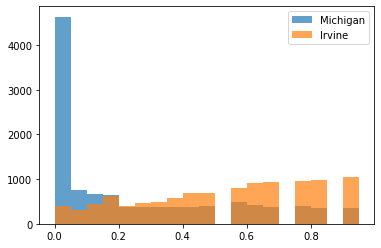

In [7]:
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
# Remove controls
michigan_c_diff = michigan_c_diff[[c for c in michigan_c_diff.columns if c not in genes_c.index]]
irvine_c_diff = irvine_c_diff[[c for c in irvine_c_diff.columns if c not in genes_c.index]]


pvals_c = {}
rejected_c = {}

# Wilcoxon signed-rank test
p_val = michigan_c_diff.apply(wilcoxon).iloc[1,:]   ;pvals_c['michigan_c_w'] = p_val
bonferr = multipletests(p_val, method='bonferroni')[0]  ;rejected_c['michigan_c_w_b'] = bonferr
bh = multipletests(p_val, method='fdr_bh')[0]   ;rejected_c['michigan_c_w_bh'] = bh
print('Wilcoxon signed-rank test')
print('Michigan')
print('rejected H0(no correction):{}'.format(sum(p_val<0.05)))
print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
print('rejected H0(BH):{} \n'.format(sum(bh)))
plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.7, label='Michigan')

p_val = irvine_c_diff.apply(wilcoxon).iloc[1,:]   ;pvals_c['irvine_c_w'] = p_val
bonferr = multipletests(p_val, method='bonferroni')[0]  ;rejected_c['irvine_c_w_b'] = bonferr
bh = multipletests(p_val, method='fdr_bh')[0]   ;rejected_c['irvine_c_w_bh'] = bonferr
print('Irvine')
print('rejected H0(no correction):{}'.format(sum(p_val<0.05)))
print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
print('rejected H0(BH):{} \n'.format(sum(bh)))
plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.7, label='Irvine')
plt.legend()

Paired t-test
Michigan
rejected H0(no correction):4870
rejected H0(bonferroni):187
rejected H0(BH):3492 

Irvine
rejected H0(no correction):380
rejected H0(bonferroni):0
rejected H0(BH):0 



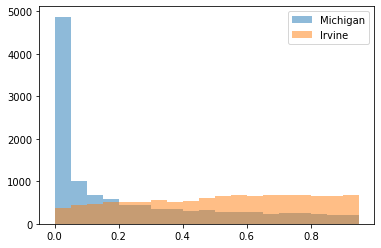

In [8]:
# Paired t-test
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

# Michigan
p_val = [ttest_1samp(michigan_c_diff.iloc[:,i], 0)[1] for i in np.arange(michigan_c_diff.shape[1])]
pvals_c['michigan_c_t'] = p_val

bonferr = multipletests(p_val, method='bonferroni')[0]    ; rejected_c['michigan_c_t_b'] = bonferr
bh = multipletests(p_val, method='fdr_bh')[0]   ; rejected_c['michigan_c_t_bh'] = bh
print('Paired t-test')
print('Michigan')
print('rejected H0(no correction):{}'.format(sum([i<0.05 for i in p_val])))
print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
print('rejected H0(BH):{} \n'.format(sum(bh)))
plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.5, label='Michigan')

# Irvine
p_val = [ttest_1samp(irvine_c_diff.iloc[:,i], 0)[1] for i in np.arange(irvine_c_diff.shape[1])]
pvals_c['irvine_c_t'] = p_val

bonferr = multipletests(p_val, method='bonferroni')[0]    ; rejected_c['irvine_c_t_b'] = bonferr
bh = multipletests(p_val, method='fdr_bh')[0]   ; rejected_c['irvine_c_t_bh'] = bh
print('Irvine')
print('rejected H0(no correction):{}'.format(sum([i<0.05 for i in p_val])))
print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
print('rejected H0(BH):{} \n'.format(sum(bh)))
plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.5, label='Irvine')
plt.legend()

## Multiple Hypothesis Testing results
The keys are represented as : {lab}_{wilcoxon/t-test}_{bonferroni/B-H}.  
The cotrol centered data gives the results that we expect.

In [9]:
print('# of rejected H0 using the actual data')
print(pd.DataFrame(rejected).apply(np.sum))

print('# of rejected H0 using the centered data')
print(pd.DataFrame(rejected_c).apply(np.sum))


# of rejected H0 using the actual data
michigan_w_b         0
michigan_w_bh    11122
irvine_w_b           0
irvine_w_bh          0
michigan_t_b       458
michigan_t_bh    11196
irvine_t_b           0
irinve_t_bh          0
dtype: int64
# of rejected H0 using the centered data
michigan_c_w_b        0
michigan_c_w_bh    3318
irvine_c_w_b          0
irvine_c_w_bh         0
michigan_c_t_b      187
michigan_c_t_bh    3492
irvine_c_t_b          0
irvine_c_t_bh         0
dtype: int64


Do the same procedure on the aggregated (Michigan + Irvine) data

Wilcoxon signed-rank test
rejected H0(no correction):3136
rejected H0(bonferroni):3
rejected H0(BH):654 

paired t-test
rejected H0(no correction):3428
rejected H0(bonferroni):3
rejected H0(BH):780 



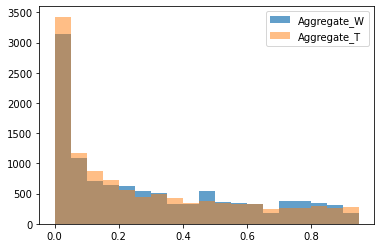

In [55]:
df = pd.concat([michigan_c_diff, irvine_c_diff])  # Row index not adjusted

# Wilcoxon signed-rank test
p_val = df.apply(wilcoxon).iloc[1,:] 
bonferr = multipletests(p_val, method='bonferroni')[0]  
bh = multipletests(p_val, method='fdr_bh')[0]  
print('Wilcoxon signed-rank test')
print('rejected H0(no correction):{}'.format(sum(p_val<0.05)))
print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
print('rejected H0(BH):{} \n'.format(sum(bh)))
plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.7, label='Aggregate_W')


# Paired t-test
p_val = [ttest_1samp(df.iloc[:,i], 0)[1] for i in np.arange(df.shape[1])]
bonferr = multipletests(p_val, method='bonferroni')[0]  
bh = multipletests(p_val, method='fdr_bh')[0]   
print('paired t-test')
print('rejected H0(no correction):{}'.format(sum([i<0.05 for i in p_val])))
print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
print('rejected H0(BH):{} \n'.format(sum(bh)))
plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.5, label='Aggregate_T')
plt.legend()


# Gene Investigation
Investigate genes(187): centered data from Michigan lab using paired t-test w/ bonferroni correction: michigan_c_t_b 

In [56]:
g = michigan_c_diff.columns[rejected_c['michigan_c_t_b']]
g_pval = np.array(pvals_c['michigan_c_t'])
g_pval = g_pval[np.array(rejected_c['michigan_c_t_b'])]
genes.loc[g]

,sym,chrom
1225_g_at,PCTK1,X
1310_at,PSMB2,1
1347_at,CDC25B,20
1383_at,PPP2R2A,8
1392_at,GRK6,5
...,...,...
472_at,STAT5B,17
534_s_at,FOLR1,11
818_s_at,ATRX,X
838_s_at,UBE2I,16


In [54]:
genes.loc[g].groupby('chrom').size().sort_values(ascending=False)

chrom
1          23
17         17
6          14
19         13
16         11
11         10
12         10
X           9
8           9
7           9
2           9
20          9
3           7
22          6
5           6
15          6
9           5
4           4
14          3
10          3
21          2
18          2
7cb*        0
10ak*       0
Un          0
X Y         0
10ptp*      0
Y           0
7ps*        0
16hba1      0
11hbg       0
13          0
45ac*       0
16nomo1     0
22gp*       0
22gg*       0
17loc*      0
15ch*       0
na          0
dtype: int64